In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gzip

In [2]:
to_dataset = []
from_dataset = []

page_node = 'Israeli–Palestinian_conflict'

for dir,_,files in os.walk('./dataset'):
    for file in files:
        with gzip.open(f'{dir}/{file}', 'rt', encoding='utf-8') as inp:
            for line in inp:
                frm, to, typ, clicks = line.strip().split('\t')
                if to == page_node:
                    to_dataset.append((file,frm,to,typ, int(clicks)))
                if frm == page_node:
                    from_dataset.append((file,frm,to,typ, int(clicks)))

In [3]:
import pandas as pd

to_df = pd.DataFrame(data=to_dataset, columns=['file', 'from','to', 'type', 'clicks_monthly'])
from_df = pd.DataFrame(data=from_dataset, columns=['file', 'from','to', 'type', 'clicks_monthly'])

In [4]:
to_df['month'] = pd.to_datetime(to_df['file'].str.replace('clickstream-enwiki-','').str.replace('.tsv.gz',''))
from_df['month'] = pd.to_datetime(from_df['file'].str.replace('clickstream-enwiki-','').str.replace('.tsv.gz',''))

<Axes: xlabel='month', ylabel='clicks_monthly'>

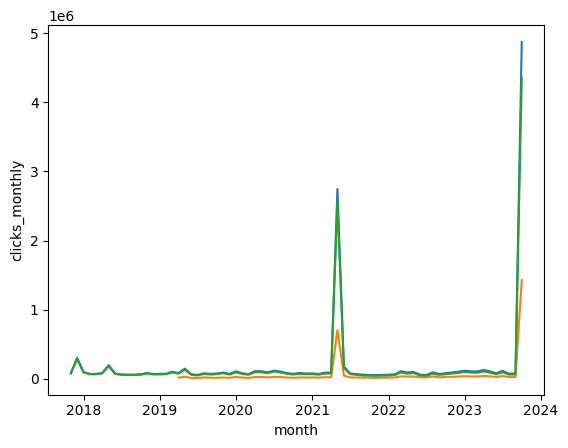

In [5]:
ax = plt.subplot()
sns.lineplot(data=to_df.groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax, errorbar=None)
sns.lineplot(data=from_df.groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax, errorbar=None)
sns.lineplot(data=to_df[to_df['type']!='link'].groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax, errorbar=None)

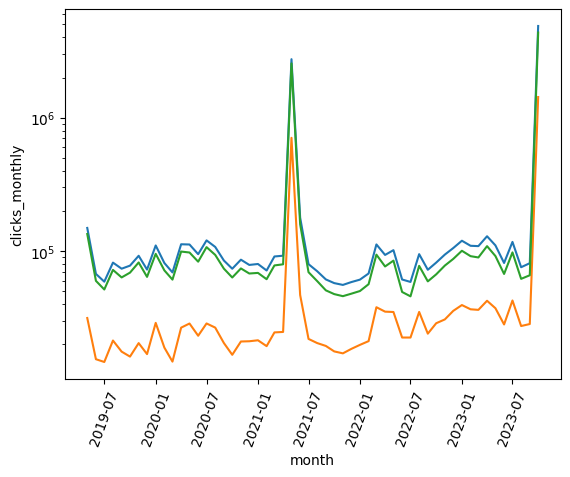

In [6]:
ax = plt.subplot()
sns.lineplot(data=to_df[to_df['month']>'2019-04'].groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax)
sns.lineplot(data=from_df[from_df['month']>'2019-04'].groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax)
sns.lineplot(data=to_df[(to_df['type']!='link')&(to_df['month']>'2019-04')].groupby('month').agg(sum), x='month', y='clicks_monthly', ax=ax, errorbar=None)
ax.set_yscale('log')
_=plt.xticks(rotation=70)

In [7]:
import numpy as np
to_agg = to_df.groupby('month').agg(sum)[['clicks_monthly']]
to_agg['sta'] = to_agg.rolling(1,min_periods=1).apply(np.mean)['clicks_monthly']
to_agg['lta'] = to_agg.rolling(15,min_periods=1).apply(np.mean)['clicks_monthly']
to_agg['ratio'] = to_agg['sta']/to_agg['lta']


from_agg = from_df.groupby('month').agg(sum)[['clicks_monthly']]
from_agg['sta'] = from_agg.rolling(1,min_periods=1).apply(np.mean)['clicks_monthly']
from_agg['lta'] = from_agg.rolling(15,min_periods=1).apply(np.mean)['clicks_monthly']
from_agg['ratio'] = from_agg['sta']/from_agg['lta']


In [8]:
spikes = to_agg[to_agg['ratio']>1.5].copy()
spikes = spikes.join(from_agg, lsuffix='_source', rsuffix='_dest').dropna(axis=0).copy()

spikes['drop_%'] = (spikes['clicks_monthly_source']-spikes['clicks_monthly_dest'])/spikes['clicks_monthly_source']

np.mean(spikes['drop_%'])


0.7462597151511079

In [9]:
spikes

,clicks_monthly_source,sta_source,lta_source,ratio_source,clicks_monthly_dest,sta_dest,lta_dest,ratio_dest,drop_%
month,,,,,,,,,
2019-05-01,148844,148844.0,89244.466667,1.667823,31408.0,31408.0,25778.000000,1.218403,0.788987
2021-05-01,2745872,2745872.0,267871.466667,10.250707,705960.0,705960.0,68205.733333,10.350450,0.742901
2023-10-01,4872049,4872049.0,416728.266667,11.691189,1428043.0,1428043.0,126631.933333,11.277116,0.706891


In [10]:
overall = to_agg.join(from_agg, lsuffix='_source', rsuffix='_dest').dropna(axis=0).copy()
overall['drop_%'] = (overall['clicks_monthly_source']-overall['clicks_monthly_dest'])/overall['clicks_monthly_source']
np.mean(overall['drop_%'])


0.7103200124102533